<div style="text-align: center;">
<strong>Machine Learning for Scientific Computing and Numerical Analysis - PC 5</strong>
</div>
<div style="text-align: center;">
<strong>Solving PDEs with Neural Nets</strong>
</div>
<div style="text-align: center;">
<p>Loïc Gouarin, Samuel Kokh, Hadrien Montanelli</p>
</div>
<div style="text-align: center;">
<i>2024 - 2025</i>
</div>

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

# 1 Computing derivatives with TensorFlow

As discussed in Lecture 5, we will use Physics-Informed Neural Networks (PINNs) to solve ODEs and PDEs. These equations involve multiple derivatives with respect to time and space.

To compute these derivatives within our trained model, we rely on automatic differentiation. The function [`GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) of TensorFlow is dedicated to this purpose.

Let’s give a really simple example to explain how it works. Suppose we have the function

$$
y(x) = x^2,
$$

and we want to compute $\frac{d y}{d x}$. We can do that with TensorFlow with the following code.

In [3]:
x = tf.Variable(3.0)

with tf.GradientTape() as g:
    y = x**2  # y(x) = x^2

dy_dx = g.gradient(y, x)  # y'(x) = 2*x

dy_dx.numpy()  # y'(3) = 6

6.0

We have the possibility to add various options during the call of `GradientTape`.

## 1.1 Persistent

If we try to call once more the gradient, we will have an error that is pretty explicit.

In [4]:
g.gradient(y, x)

RuntimeError: A non-persistent GradientTape can only be used to compute one set of gradients (or jacobians)

Therefore, we have to modify our code and add the `persistent` keyword during the construction of our gradient.

In [5]:
with tf.GradientTape(persistent=True) as g:
    y = x**2

g.gradient(y, x)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

In [6]:
g.gradient(y, x)

<tf.Tensor: shape=(), dtype=float32, numpy=6.0>

## 1.2 Watch

In the previous example, we didn’t specify which variables to use for differentiation. By default, all `tf.Variable` instances are included in the scope. However, we may want to control which variables are differentiated.

Let's take this simple example:

In [7]:
with tf.GradientTape(watch_accessed_variables=False) as g:
    y = x**2

print(g.gradient(y, x))

None


We can observe that the derivative of `y` in `x` doesn't exist anymore. Using this option, how can we retrieve the previous behavior? We can use the method `watch` from the `GradientTape` to indicate which variables are used for differentiation.

In [8]:
with tf.GradientTape(watch_accessed_variables=False) as g:
    g.watch(x)
    y = x**2

print(g.gradient(y, x))

tf.Tensor(6.0, shape=(), dtype=float32)


### Exercise

{exercise}
Consider the following function

$$
f(x, y) = \sin(2\pi x)y.
$$

Compute $\frac{\partial^2 f}{\partial x \partial y}$.

In [9]:
x = tf.Variable(1.0, dtype=DTYPE)
y = tf.Variable(5, dtype=DTYPE)

with tf.GradientTape(watch_accessed_variables=False) as g:
    g.watch(x)
    with tf.GradientTape(watch_accessed_variables=False) as gg:
        gg.watch(y)
        f = tf.sin(2*np.pi*x)*y
    df_dy = gg.gradient(f,y)
d2f_dxy = g.gradient(df_dy,x)

### Validation

In [10]:
d2f_dxy.numpy()  # you should get 2*pi

6.2831855

We can use automatic differentiation in TensorFlow on almost every TensorFlow objects. The following example plots a sigmoid function and its derivative.

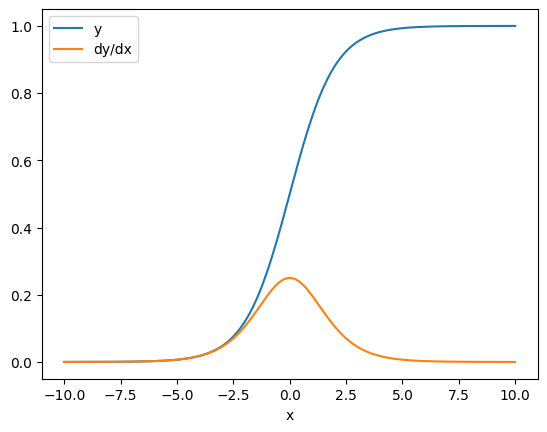

In [11]:
x = tf.linspace(-10.0, 10.0, 200 + 1)

with tf.GradientTape() as tape:
    tape.watch(x)
    y = tf.nn.sigmoid(x)

dy_dx = tape.gradient(y, x)

plt.plot(x, y, label="y")
plt.plot(x, dy_dx, label="dy/dx")
plt.legend()
_ = plt.xlabel("x")

If you'd like to learn more about automatic differentiation in TensorFlow, check out https://www.tensorflow.org/guide/autodiff.

# 2 Setting up PINNs

# 2.1 Neural network class

### Exercise

{exercise}
Complete the missing parts in the creation of the neural network model.

In [12]:
def create_model(
    neurons,
    *,
    input_size=1,
    output_size=1,
    activation="tanh",
    initializer="glorot_normal",
):
    """
    Creates a Sequential Keras model with the specified parameters.

        Parameters
        ----------
        neurons : list of int
            A list where each element represents the number of neurons in a hidden layer.
        input_size : int, optional
            The size of the input layer. Default is 1.
        output_size : int, optional
            The size of the output layer. Default is 1.
        activation : str, optional
            The activation function to use for the hidden layers. Default is 'tanh'.
        initializer : str, optional
            The initializer for the kernel weights matrix. Default is 'glorot_normal'.

        Returns
        -------
        tf.keras.Sequential
            A Keras Sequential model with the specified architecture.
    """

    # Setup model:
    model = tf.keras.Sequential()

    # Input layer:
    model.add(tf.keras.layers.InputLayer(input_shape=(input_size,)))  

    # Loop over hidden layers:
    for dl in neurons:
        model.add(tf.keras.layers.Dense(dl, activation=activation, kernel_initializer=initializer))

    # Output layer:
    model.add(tf.keras.layers.Dense(output_size, activation=None))
    model.num_output = output_size

    return model

# 2.2 Grids in 1D

### Exercise

{exercise}
Complete the missing parts in the creation of the 1D grid.

In [13]:
def grid1D(n_r, dom, gridtype):
    """
    Generates a 1D grid of points based on the specified grid type.

    Parameters
    ----------
    n_r : int
        The number of points in the grid.
    dom : tuple of float
        The domain limits (lower bound, upper bound).
    gridtype : str
        The type of grid to generate. Options are:
        - 'rand': Randomly distributed points in the domain.
        - 'uniform': Equally spaced points in the domain.
        - 'midpoint': Midpoints of a uniform grid.

    Returns
    -------
    x_r : tf.Tensor
        The grid points of shape (n_r, 1).
    x_b : tf.Tensor
        The boundary points of shape (2,), corresponding to `dom[0]` and `dom[1]`.

    Notes
    -----
    - The random grid uses `tf.random.uniform` to sample points from a uniform distribution.
    - The uniform grid uses `tf.linspace` to create evenly spaced points.
    - The midpoint grid is computed as the midpoints of a uniform grid.
    - The output tensors are cast to `DTYPE`.
    """

    if gridtype == "rand":
        x_r = tf.random.uniform(shape=(n_r, 1), minval=dom[0], maxval=dom[1])

    elif gridtype == "uniform":
        x_r = tf.linspace(dom[0],dom[1], n_r+1)

    elif gridtype == "midpoint":
        x_r = tf.linspace(dom[0], dom[1], n_r + 1)
        x_r = 1 / 2 * (x_r[0:n_r] + x_r[1 : n_r + 1])
        x_r = tf.reshape(x_r, (n_r, 1))

    x_r = tf.cast(x_r, dtype=DTYPE)
    x_b = tf.constant([dom[0], dom[1]], dtype=DTYPE)

    return x_r, x_b

# 2.3 Grids in 2D

### Exercise

{exercise}
Complete the missing parts in the creation of the 2D grid.

In [ ]:
def grid2D(n_r, n_b, n_i, dom):
    """
    Generates a 2D grid of points for solving PDEs on a rectangular domain.

    Parameters
    ----------
    n_r : int
        The number of residual points inside the domain.
    n_b : int
        The number of boundary points along each spatial boundary.
    n_i : int
        The number of initial condition points.
    dom : tuple of float
        The domain limits in the form (t_min, t_max, x_min, x_max).

    Returns
    -------
    X_r : tf.Tensor
        The residual points of shape (n_r, 2), representing (t, x) pairs.
    X_b : tf.Tensor
        The boundary points of shape (n_i + 2*n_b, 2), representing (t, x) pairs.
    u_b : tf.Tensor
        The boundary condition values at the boundary points of shape (n_i + 2*n_b, 1).

    Notes
    -----
    - The domain is defined as `[t_min, t_max] x [x_min, x_max]`.
    - Residual points `(t_r, x_r)` are sampled uniformly from the domain.
    - Boundary points include:
        - Initial condition = left boundary (`t_min`, varying `x`).
        - Boundary conditions = top and bottom boudaries (`x_min`, varying `t` and `x_max`, varying `t`).
    - The function `u0(x)` provides the initial condition values at `t_min`.
    """

     # PDE is on [t_min, t_max] x [x_min, x_max]:
    t_min = dom[0]
    t_max = dom[1]
    x_min = dom[2]
    x_max = dom[3]

    # Residual points in time:
    t_r = tf.random.uniform(shape=(n_r, 1), minval=t_min, maxval=t_max, dtype=DTYPE)

    # Residual points in space:
    x_r = tf.random.uniform((n_r, 1), minval=x_min, maxval=x_max, dtype=DTYPE)

    # Residual points in time and space:
    X_r = tf.concat([t_r, x_r], axis=1)

    # Boundary points in time:
    t_left = tf.random.uniform((n_i, 1), minval=t_min, maxval=t_min, dtype=DTYPE)
    t_top = tf.random.uniform((n_b, 1), minval=t_min, maxval=t_max, dtype=DTYPE)
    t_bottom = tf.random.uniform((n_b, 1), minval=t_min, maxval=t_max, dtype=DTYPE)
    t_b = tf.concat([t_left, t_top, t_bottom], axis=0)

    # Boundary points in space:
    x_left = tf.random.uniform((n_i, 1), minval=x_min, maxval=x_max, dtype=DTYPE)
    x_top = tf.random.uniform((n_b, 1), minval=x_min, maxval=x_min, dtype=DTYPE)
    x_bottom = tf.random.uniform((n_b, 1), minval=x_max, maxval=x_max, dtype=DTYPE)
    x_b = tf.concat([x_left, x_top, x_bottom], axis=0)

    # Boundary points in time and space:
    X_b = tf.stack([t_b, x_b], axis=1)

    # Boundary data:
    u_left = u0(x_left)
    u_top = 0 * t_top
    u_bottom = 0 * t_bottom
    u_b = tf.concat([u_left, u_top, u_bottom], axis=0)
    u_b = tf.constant(u_b, shape=(n_i + 2 * n_b, 1))

    return X_r, X_b, u_b

# 3 Solving elliptic PDEs

## 3.1 Poisson equation

We consider the one-dimensional Poisson equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x) = f(x), \quad x \in(-1,1), \\
& u(-1) = u(1) = 0.
\end{align}

We will take the following right-hand side and exact solution,

$$
f(x) = (2\pi)^2\sin(2\pi x), \quad u(x) = \sin(2\pi x).
$$

### Exercise

{exercise}
Complete the missing parts in the computation of the residual, loss, and gradient. Then:

- setup a neural network model with 5 layers with 25 neurons each [Step 1];
- choose $\gamma=1$ and $n_r=100$ residual points [Step 2];
- try the three different 1D grids of `grid1D` [Step 2];
- choose 5000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-3}$ for the loss (`loss_min`) [Step 3].

The displayed $L^\infty$-error should be around $10^{-3}$.

In [15]:
###########################################################
# Residual, loss, and gradient
###########################################################

# ODE setup:
dom = [-1, 1]
f = lambda x: (2 * np.pi) ** 2 * tf.sin(2 * np.pi * x)
u_exact = lambda x: np.sin(2 * np.pi * x)


# Define residual of the ODE:
def residual(x, u_xx):
    return -u_xx-f(x)

# Residual computation:
def compute_res(model, x_r):
    with tf.GradientTape(
        persistent=True, watch_accessed_variables=False
    ) as tape:  # replace me
        tape.watch(x_r)
        u = model(x_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(x_r, u_xx)
    return res


# Loss function computation:
def compute_loss(model, x_r, x_b, u_b, gamma):
    # Loss on residual:
    res = compute_res(model, x_r)
    loss_r = tf.reduce_mean(tf.square(res))

    # Loss on boundary points:
    u_pred = model(x_b)
    loss_b = tf.reduce_mean(tf.square(u_pred - u_b))

    # Total loss:
    loss = loss_r+gamma*loss_b

    return loss, loss_r, loss_b


# Gradient computation:
def compute_grad(model, x_r, x_b, u_b, gamma=1):
    with tf.GradientTape(persistent=True) as tape:
        loss, loss_r, loss_b = compute_loss(model, x_r, x_b, u_b, gamma)

    grad = tape.gradient(loss, model.trainable_variables)

    return loss, grad, loss_r, loss_b


###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([25, 25, 25, 25, 25])
model.residual = residual

# Method parameters (Step 2):
gamma = 1
n_r = 100

# Residual and boundary points, and boundary condition (Step 2):
x_r, x_b = grid1D(n_r, dom, "uniform")
u_b = tf.constant([0, 0], shape=(2, 1), dtype=DTYPE)

# Optimization setup (Step 3):
itr_max = 5000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [1000, 3000], [1e-2, 1e-3, 5e-4]
)
optim = tf.keras.optimizers.Adam(learning_rate=lr)


@tf.function
def train_step():
    loss, grad, loss_r, loss_b = compute_grad(model, x_r, x_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return loss, loss_r, loss_b

C:\Users\ethan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


### Validation

Time: 13.60750s
Error (L-inf): 1.14e-03


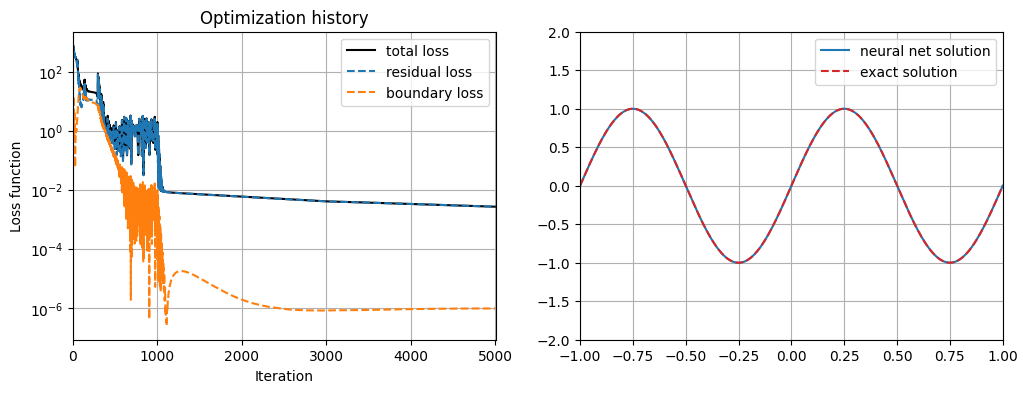

In [16]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while itr < itr_max + 1 and loss > loss_min:
    loss, loss_r, loss_b = train_step()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
t1 = time.time()
print(f"Time: {t1-t0:.5f}s")

# Compute neural net and exact solutions on a different grid:
n_plot = 1000
x_plot = np.linspace(dom[0], dom[1], n_plot)
u_pred = tf.reshape(model(tf.cast(x_plot, DTYPE)), (n_plot,))
u_ex = u_exact(x_plot)
error = np.max(np.abs(u_ex - u_pred)) / np.max(np.abs(u_ex))
print(f"Error (L-inf): {error:.2e}")

# Plot loss function:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist, "k-", label="total loss")
axs[0].semilogy(range(len(hist)), hist_r, "--", label="residual loss")
axs[0].semilogy(range(len(hist)), hist_b, "--", label="boundary loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss function")
axs[0].set_title("Optimization history")
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc="best", fontsize=10)

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label="neural net solution", color="tab:blue")
axs[1].plot(x_plot, u_ex, "--", label="exact solution", color="tab:red")
axs[1].set_xlim(dom[0], dom[1])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc="best", fontsize=10)

## 3.2 Constant-coefficient elliptic problem

Let $\mu>0$. We consider the following one-dimensional ellipic problem with homogeneous Dirichlet boundary conditions:

\begin{align}
& -u''(x) + \mu u(x) = f(x), \quad x \in(-1,1), \\
& u(-1) = u(1) = 0.
\end{align}

We will take the following right-hand side and exact solution for $\mu=1$,

$$
f(x) = [(2\pi)^2 + \mu]\sin(2\pi x), \quad u(x) = \sin(2\pi x).
$$


### Exercise

{exercise}
Complete the missing parts in the computation of the residual. Then:

- setup a neural network model with 5 layers with 25 neurons each [Step 1];
- choose $\gamma=1$ and $n_r=100$ residual points [Step 2];
- try the three different 1D grids of `grid1D` [Step 2];
- choose 5000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-3}$ for the loss (`loss_min`) [Step 3].

The displayed $L^\infty$-error should be around $10^{-3}$.

In [17]:
###########################################################
# Residual
###########################################################

# ODE setup:
dom = [-1, 1]
mu = 1
f = lambda x: ((2 * np.pi) ** 2 + mu) * tf.sin(2 * np.pi * x)
u_exact = lambda x: np.sin(2 * np.pi * x)


# Define residual of the ODE:
def residual(x, u, u_xx):
    return -u_xx+mu*u-f(x)


# Residual computation:
def compute_res(model, X_r):
    with tf.GradientTape(
        persistent=True, watch_accessed_variables=False
    ) as tape:
        tape.watch(X_r)
        u = model(X_r)
        u_x = tape.gradient(u,X_r)
        u_xx = tape.gradient(u_x, X_r)
        res = model.residual(X_r, u, u_xx)

    return res


###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([25, 25, 25, 25, 25])
model.residual = residual

# Method parameters (Step 2):
gamma = 1
n_r = 100

# Residual and boundary points, and boundary condition (Step 2):
x_r, x_b = grid1D(n_r, dom, "midpoint")
u_b = tf.constant([0, 0], shape=(2, 1), dtype=DTYPE)

# Optimization setup (Step 3):
itr_max = 5000
loss_min = 1e-3
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [1000, 3000], [1e-2, 1e-3, 5e-4]
)
optim = tf.keras.optimizers.Adam(learning_rate=lr)


@tf.function
def train_step():
    loss, grad, loss_r, loss_b = compute_grad(model, x_r, x_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return loss, loss_r, loss_b

### Validation

Time: 12.70200s
Error (L-inf): 4.99e-03


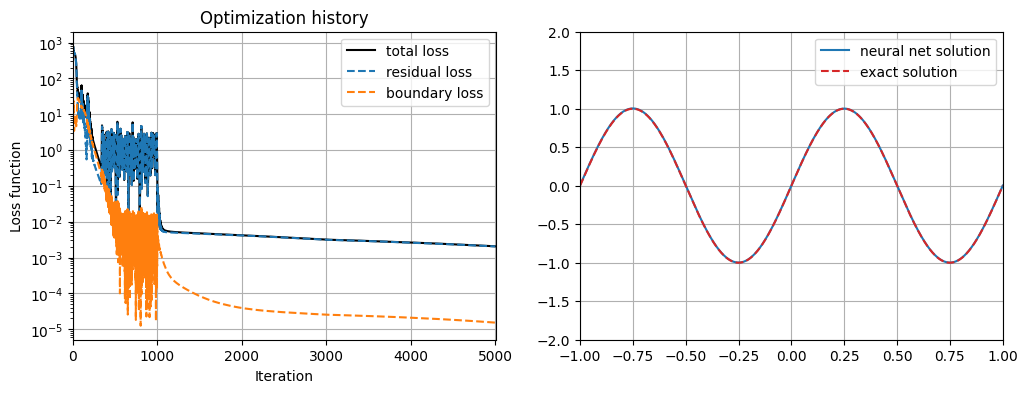

In [18]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while itr < itr_max + 1 and loss > loss_min:
    loss, loss_r, loss_b = train_step()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
t1 = time.time()
print(f"Time: {t1-t0:.5f}s")

# Compute neural net and exact solutions on a different grid:
n_plot = 1000
x_plot = np.linspace(dom[0], dom[1], n_plot)
u_pred = tf.reshape(model(tf.cast(x_plot, DTYPE)), (n_plot,))
u_ex = u_exact(x_plot)
error = np.max(np.abs(u_ex - u_pred)) / np.max(np.abs(u_ex))
print(f"Error (L-inf): {error:.2e}")

# Plot loss function:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist, "k-", label="total loss")
axs[0].semilogy(range(len(hist)), hist_r, "--", label="residual loss")
axs[0].semilogy(range(len(hist)), hist_b, "--", label="boundary loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss function")
axs[0].set_title("Optimization history")
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc="best", fontsize=10)

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label="neural net solution", color="tab:blue")
axs[1].plot(x_plot, u_ex, "--", label="exact solution", color="tab:red")
axs[1].set_xlim(dom[0], dom[1])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc="best", fontsize=10)

# 4 Solving parabolic PDEs

## 4.1 Heat equation

We consider the one-dimensional heat equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& u_t(t,x) = u_{xx}(x,t), && t\in[0,T], \quad x\in(-1,1), \\
& u(t,x) = u(t,x) = 0, && t\in[0,T], \\
& u(0,x) = u_0(x), && x\in(-1,1).
\end{align}

We will take $T=10^{-2}$, and the following intial condition and exact solution,

$$
u_0(x) = \sin(\pi x), \quad u(t,x) = \sin(\pi x)e^{-\pi^2 t}.
$$

### Exercise

{exercise}
Complete the missing parts in the computation of the residual, loss, and gradient. Then:

- setup a neural network model with 5 layers with 25 neurons each [Step 1];
- choose $\gamma=10$, $n_r=200$ residual points, and $n_b=n_i=20$ boundary points [Step 2];
- setup the grid with `grid2D` [Step 2];
- choose 5000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-5}$ for the loss (`loss_min`) [Step 3].

The displayed $L^\infty$-error should be around $10^{-2}$.

In [19]:
###########################################################
# Residual, loss, and gradient
###########################################################

# PDE setup:
T = 1e-2
dom = [0, T, -1, 1]
u0 = lambda x: tf.sin(np.pi * x)
u_exact = lambda t, x: np.sin(np.pi * x) * np.exp(-((np.pi) ** 2) * t)


# Define residual of the PDE:
def residual(model, x, u, u_t, u_xx):
    return u_t-u_xx


# Residual computation:
def compute_res(model, X_r):
    t_r = X_r[:, 0:1]
    x_r = X_r[:, 1:2]

    with tf.GradientTape(
        persistent=True, watch_accessed_variables=False
    ) as tape:  # replace me
        tape.watch(t_r)
        tape.watch(x_r)
        g = tf.stack([t_r[:, 0], x_r[:, 0]], axis=1)
        u = model(g)
        u_t = tape.gradient(u,t_r)
        u_x = tape.gradient(u,x_r)
        u_xx = tape.gradient(u_x,x_r)
        res = model.residual(model, X_r, u, u_t, u_xx)

        return res


# Loss function computation:
def compute_loss(model, X_r, X_b, u_b, gamma):
    # Loss on residual:
    res = compute_res(model, X_r)
    loss_r = tf.reduce_mean(tf.square(res))

    # Loss on boundary points:
    u_pred = model(X_b)
    loss_b = tf.reduce_mean(tf.square(u_pred - u_b))

    # Total loss:
    loss = loss_r+gamma*loss_b

    return loss, loss_r, loss_b


# Gradient computation:
def compute_grad(model, X_r, X_b, u_b, gamma=1):
    with tf.GradientTape(persistent=True) as tape:
        loss, loss_r, loss_b = compute_loss(model, X_r, X_b, u_b, gamma)
    grad = tape.gradient(loss, model.trainable_variables)

    return loss, grad, loss_r, loss_b


###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([25, 25, 25, 25, 25], input_size=2)
model.residual = residual

# Method parameters (Step 2):
gamma = 10  # replace me
n_r = 200
n_b = 20
n_i = 20

# Residual and boundary points, and boundary condition (Step 2):
X_r, X_b, u_b = grid2D(n_r, n_b, n_i, dom)

# Optimization setup (Step 3):
itr_max = 5000
loss_min = 1e-5
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [1000, 3000], [1e-2, 1e-3, 5e-4]
)
optim = tf.keras.optimizers.Adam(learning_rate=lr)


@tf.function
def train_step():
    loss, grad, loss_r, loss_b = compute_grad(model, X_r, X_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return loss, loss_r, loss_b

### Validation

Time: 18.77550s
Error (L-inf): 1.13e-02


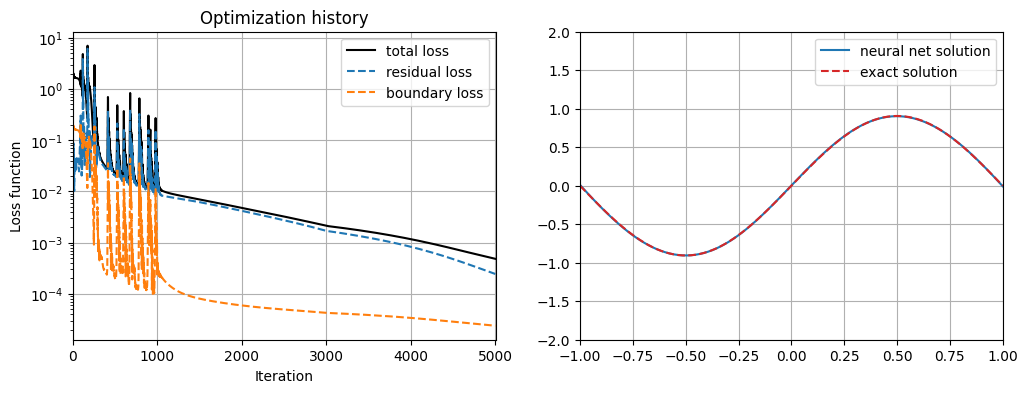

In [20]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while itr < itr_max + 1 and loss > loss_min:
    loss, loss_r, loss_b = train_step()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
t1 = time.time()
print(f"Time: {t1-t0:.5f}s")

# Compute neural net and exact solutions on a different grid:
n_plot = 100
x_plot = np.linspace(-1, 1, n_plot)
u_pred = np.zeros(n_plot)
for i in range(n_plot):
    tmp = tf.constant([T, x_plot[i]], shape=(1, 2), dtype=DTYPE)
    u_pred[i] = model(tf.cast(tmp, DTYPE))
u_ex = u_exact(T, x_plot)
error = np.max(np.abs(u_ex - u_pred)) / np.max(np.abs(u_ex))
print(f"Error (L-inf): {error:.2e}")

# Plot loss function:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist, "k-", label="total loss")
axs[0].semilogy(range(len(hist)), hist_r, "--", label="residual loss")
axs[0].semilogy(range(len(hist)), hist_b, "--", label="boundary loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss function")
axs[0].set_title("Optimization history")
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc="best", fontsize=10)

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label="neural net solution", color="tab:blue")
axs[1].plot(x_plot, u_ex, "--", label="exact solution", color="tab:red")
axs[1].set_xlim(dom[2], dom[3])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc="best", fontsize=10)

## 4.2 Allen-Cahn equation

We consider the one-dimensional Allen-Cahn equation with homogeneous Dirichlet boundary conditions:

\begin{align}
& u_t(t,x) = \epsilon u_{xx}(x,t) + u - u^3, && t\in[0,T], \quad x\in(-1,1), \\
& u(t,x) = u(t,x) = 0, && t\in[0,T], \\
& u(0,x) = u_0(x), && x\in(-1,1).
\end{align}

We will take $T=1$, $\epsilon=10^{-2}$, and the following intial condition,

$$
u_0(x) = e^{-100(x+0.5)^2} - e^{-100(x-0.5)^2}.
$$

### Exercise

{exercise}
Complete the missing parts in the computation of the residual. Then:

- setup a neural network model with 5 layers with 25 neurons each [Step 1];
- choose $\gamma=10$, $n_r=500$ residual points, and $n_b=n_i=50$ boundary points [Step 2];
- setup the grid with `grid2D` [Step 2];
- choose 5000 iterations maximum (`itr_max`) and a stopping criteria of $10^{-5}$ for the loss (`loss_min`) [Step 3].

The displayed $L^\infty$-error should be around $10^{-2}$.

In [21]:
###########################################################
# Residual
###########################################################

# PDE setup:
T = 1
dom = [0, T, -1, 1]
eps = 1e-2
u0 = lambda x: tf.exp(-100 * (x + 0.5) ** 2) - tf.exp(-100 * (x - 0.5) ** 2)
u_ex = np.loadtxt("uex-ac (2).txt")


# Define residual of the PDE:
def residual(model, x, u, u_t, u_xx):
    return u_t-eps*u_xx-u+u**3


###########################################################
# Algorithm
###########################################################

# Initiliaze neural network model (Step 1):
model = create_model([25] * 5, input_size=2)
model.residual = residual

# Method parameters (Step 2):
gamma = 10  # replace me
n_r = 500  # replace me
n_b = 50  # replace me
n_i = 50  # replace me

# Residual and boundary points, and boundary condition (Step 2):
X_r, X_b, u_b = grid2D(n_r, n_b, n_i, dom)

# Optimization setup (Step 3):
itr_max = 5000  
loss_min = 1e-5 
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    [1000, 3000], [1e-2, 1e-3, 5e-4]
)
optim = tf.keras.optimizers.Adam(learning_rate=lr)


@tf.function
def train_step():
    loss, grad, loss_r, loss_b = compute_grad(model, X_r, X_b, u_b, gamma)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    return loss, loss_r, loss_b

### Validation

Time: 23.54534s
Error (L-inf): 1.37e-02


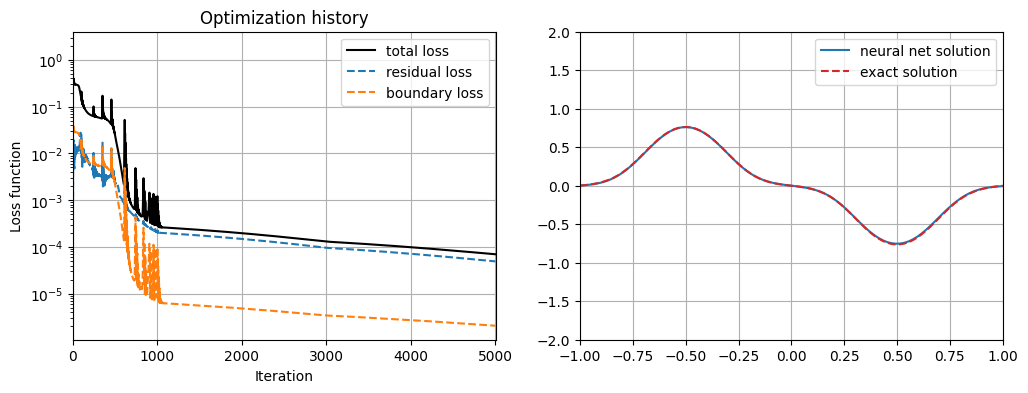

In [22]:
# Optimization loop:
hist = []
hist_r = []
hist_b = []
loss = 1
itr = 1
t0 = time.time()
while itr < itr_max + 1 and loss > loss_min:
    loss, loss_r, loss_b = train_step()
    hist.append(loss.numpy())
    hist_r.append(loss_r.numpy())
    hist_b.append(loss_b.numpy())
    itr += 1
t1 = time.time()
print(f"Time: {t1-t0:.5f}s")

# Compute neural net and exact solutions on a different grid:
n_plot = 100
x_plot = np.linspace(-1, 1, n_plot)
u_pred = np.zeros(n_plot)
for i in range(n_plot):
    tmp = tf.constant([T, x_plot[i]], shape=(1, 2), dtype=DTYPE)
    u_pred[i] = model(tf.cast(tmp, DTYPE))
error = np.max(np.abs(u_ex - u_pred)) / np.max(np.abs(u_ex))
print(f"Error (L-inf): {error:.2e}")

# Plot loss function:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].semilogy(range(len(hist)), hist, "k-", label="total loss")
axs[0].semilogy(range(len(hist)), hist_r, "--", label="residual loss")
axs[0].semilogy(range(len(hist)), hist_b, "--", label="boundary loss")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Loss function")
axs[0].set_title("Optimization history")
axs[0].set_xlim(0, itr)
axs[0].grid(1)
axs[0].legend(loc="best", fontsize=10)

# Plot neural net and exact solutions:
axs[1].plot(x_plot, u_pred, label="neural net solution", color="tab:blue")
axs[1].plot(x_plot, u_ex, "--", label="exact solution", color="tab:red")
axs[1].set_xlim(dom[2], dom[3])
axs[1].set_ylim(-2, 2)
axs[1].grid(1)
axs[1].legend(loc="best", fontsize=10)

# Lecture questions (Chapter 4)

{exercise 9}
Prove that the $m\times m$ matrices $A$ and $M$ of section 2 have entries
\begin{align}
A = \frac{1}{h}\begin{pmatrix}
\phantom{-}2 & -1 \\
-1 & \phantom{-}2 & -1\\
& \ddots & \ddots & \ddots \\
& & -1 & \phantom{-}2 & -1 \\
& & & -1 & \phantom{-}2
\end{pmatrix}, \qquad
M = \frac{h}{3}\begin{pmatrix}
2 & 0.5 \\
0.5 & 2 & 0.5\\
& \ddots & \ddots & \ddots \\
& & 0.5 & 2 & 0.5 \\
& & & 0.5 & 2
\end{pmatrix}.
\end{align}

{exercise 10}
Prove that the eigenvalues of $A$ and $M$ are
\begin{align}
\lambda_j(A) = \frac{4}{h}\sin\left(\frac{j\pi h}{4}\right)^2, \qquad
\lambda_j(M) = \frac{h}{3}\left(1 + 2\cos\left(\frac{j\pi h}{4}\right)^2\right), \qquad j=1,\ldots,m.
\end{align}

{exercise 11}
Prove that backward Euler (AM1) and AM2 are consistent of order $1$ and $2$, respectively.

*Hint: use Taylor series as in equation (33).*

{exercise 12}
Show that AM2 is stable by computing the roots of its characteristic polynomial $\rho(z)$ (see Theorem 5).

{exercise 13}
Show that the stability region $S$ of AM2 is the left-half plane by computing the roots of its characteristic polynomial $\pi(z)$ (see Theorem 9).

# Lecture questions (Chapter 5)

{exercise 14}
Show that if $f\in C^2([-1,1])$, the midpoint rule for approximating the integral $I$ with $I_n$ generates errors that are $\mathcal{O}(n^2)$.

{exercise 15}
Show that if $A=A^T$ is a $m\times m$ symmetric matrix, then $\Vert A\Vert_2=\lambda_{\max}(A)$.